## Synthetic spectra generator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
max_features = 15
n_points = 640
nu = np.linspace(0,1,n_points)

In [14]:
def random_chi3():
    """
    generates a random spectrum, without NRB. 
    output:
        params =  matrix of parameters. each row corresponds to the [amplitude, resonance, linewidth] of each generated feature (n_lor,3)
    """
    n_lor = np.random.randint(1,max_features)
    a = np.random.uniform(0,1,n_lor)
    w = np.random.uniform(0,1,n_lor)
    g = np.random.uniform(0.001,0.008, n_lor)
    
    params = np.c_[a,w,g]
    return params

print(random_chi3())

[[0.92134552 0.65895385 0.00782521]
 [0.11145721 0.37363787 0.004746  ]
 [0.70794691 0.71560684 0.00787147]
 [0.59344346 0.51362651 0.00600561]
 [0.72301669 0.52000877 0.00781572]
 [0.69224658 0.19937076 0.00617995]
 [0.49060875 0.25599301 0.00570698]
 [0.17592176 0.3601361  0.00440258]
 [0.15334628 0.79873602 0.00214272]
 [0.37013307 0.76137989 0.00757893]
 [0.22466445 0.231807   0.00683291]]


In [18]:
def build_chi3(params):
    """
    buiilds the normalized chi3 complex vector
    inputs: 
        params: (n_lor, 3)
    outputs
        chi3: complex, (n_points, )
    """
    
    chi3 = np.sum(params[:,0]/(-nu[:,np.newaxis]+params[:,1]-1j*params[:,2]),axis = 1)
    
    return chi3/np.max(np.abs(chi3))  

In [19]:
def sigmoid(x,c,b):
	return 1/(1+np.exp(-(x-c)*b))

In [20]:
def generate_nrb():
    """
    Produces a normalized shape for the NRB
    outputs
        NRB: (n_points,)
    """
    bs = np.random.normal(10,5,2)
    c1 = np.random.normal(0.2,0.3)
    c2 = np.random.normal(0.7,.3)
    cs = np.r_[c1,c2]
    sig1 = sigmoid(nu, cs[0], bs[0])
    sig2 = sigmoid(nu, cs[1], -bs[1])
    nrb  = sig1*sig2
    return nrb

In [21]:
def get_spectrum():
    """
    Produces a cars spectrum.
    It outputs the normalized cars and the corresponding imaginary part.
    Outputs
        cars: (n_points,)
        chi3.imag: (n_points,)
    """
    chi3 = build_chi3(random_chi3())*np.random.uniform(0.3,1)
    nrb = generate_nrb()
    noise = np.random.randn(n_points)*np.random.uniform(0.0005,0.003)
    cars = ((np.abs(chi3+nrb)**2)/2+noise)
    return cars, chi3.imag

In [22]:
import tensorflow as tf
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Conv1D, Flatten, BatchNormalization, Activation, Dropout
from keras import regularizers
from datetime import datetime

In [23]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

IndexError: list index out of range

In [26]:
tf.keras.backend.clear_session()
model = Sequential()

model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None,input_shape = (n_points, 1)))

model.add(Activation('relu'))

model.add(Conv1D(128, activation = 'relu', kernel_size = (32)))
model.add(Conv1D(64, activation = 'relu', kernel_size = (16)))
model.add(Conv1D(16, activation = 'relu', kernel_size = (8)))
model.add(Conv1D(16, activation = 'relu', kernel_size = (8)))
model.add(Conv1D(16, activation = 'relu', kernel_size = (8)))
model.add(Dense(32, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1 = 0, l2=0.1)))
model.add(Dense(16, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1 = 0, l2=0.1)))
model.add(Flatten())
model.add(Dropout(.25))
model.add(Dense(n_points, activation='relu'))


model.compile(loss='mse', optimizer='Adam', metrics=['mean_absolute_error','mse','accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 640, 1)            4         
_________________________________________________________________
activation (Activation)      (None, 640, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 609, 128)          4224      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 594, 64)           131136    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 587, 16)           8208      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 580, 16)           2064      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 573, 16)           2

## Training

In [27]:
def generate_batch(size = 10000):
    X = np.empty((size, n_points,1))
    y = np.empty((size,n_points))
    
    for i in range(size):
        X[i,:,0], y[i,:] = get_spectrum()
    return X, y

Epoch 1/10
147/147 [==============================] - 555s 4s/step - loss: 2.3827 - mean_absolute_error: 0.0258 - mse: 0.0038 - accuracy: 0.0683 - val_loss: 1.1009 - val_mean_absolute_error: 0.0187 - val_mse: 0.0027 - val_accuracy: 0.2440
Epoch 2/10
147/147 [==============================] - 593s 4s/step - loss: 0.5746 - mean_absolute_error: 0.0169 - mse: 0.0018 - accuracy: 0.3504 - val_loss: 0.2350 - val_mean_absolute_error: 0.0138 - val_mse: 0.0014 - val_accuracy: 0.4730
Epoch 3/10
147/147 [==============================] - 583s 4s/step - loss: 0.1129 - mean_absolute_error: 0.0143 - mse: 0.0013 - accuracy: 0.4870 - val_loss: 0.0396 - val_mean_absolute_error: 0.0119 - val_mse: 9.7021e-04 - val_accuracy: 0.5918
Epoch 4/10
147/147 [==============================] - 543s 4s/step - loss: 0.0177 - mean_absolute_error: 0.0117 - mse: 9.1802e-04 - accuracy: 0.5685 - val_loss: 0.0056 - val_mean_absolute_error: 0.0094 - val_mse: 6.9483e-04 - val_accuracy: 0.6567
Epoch 5/10
147/147 [============

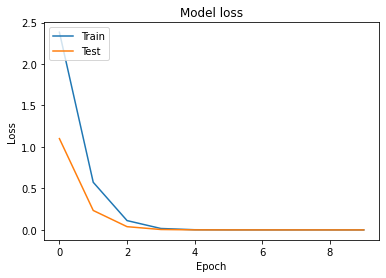

In [28]:
X, y = generate_batch(50000)
history = model.fit(X, y,epochs=10, verbose = 1, validation_split=0.25, batch_size=256) 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Use this function to test the model on single instances

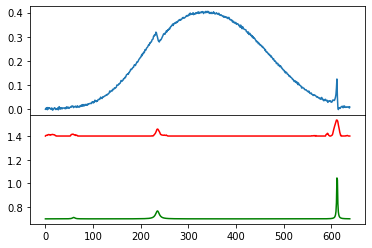

In [39]:
def predict_and_plot():
    x,y = generate_batch(1)
    yhat = model.predict(x, verbose =0)
    f, a = plt.subplots(2,1, sharex=True)
    a[0].plot(x.flatten(), label = 'cars')
    a[1].plot(y.T+.7, label = 'true',c= 'g' )
    a[1].plot(yhat.flatten()+1.4, label = 'pred.',c='r')
    plt.subplots_adjust(hspace=0)
    #return x, y.flatten(), yhat.flatten(), chi3, NRB
predict_and_plot()

[-9.15747920e-04  1.78619902e-03  1.59305755e-03  5.71405723e-05
 -9.50016099e-04 -1.60941347e-03  2.76517516e-03  1.58249452e-04
  2.88296625e-03  1.26751415e-04  1.05765047e-03  4.84886207e-03
  8.14789852e-04  1.09961729e-03 -6.00255023e-04 -1.34751509e-03
  7.58193489e-04  3.09546461e-04  4.63699068e-04  1.83454169e-03
  1.57680040e-03  1.43149148e-03  4.24419233e-04  1.12566820e-03
  1.15455686e-03  2.66686147e-03  3.88400410e-03  2.89670775e-03
  1.20002107e-03  6.56360227e-04  1.46143146e-03  3.60931294e-03
  4.22368991e-03  5.60025437e-03  4.03254288e-03  5.50485305e-04
  4.24696990e-03  1.14630646e-03  3.16364950e-03  2.83244323e-03
  6.66868000e-03 -2.83263972e-04  1.75328988e-03  2.36599868e-04
  4.23957729e-03  3.26745394e-03  2.86535586e-03  4.09184384e-03
  2.91997629e-03  3.45730436e-03  2.04363709e-03  1.44263036e-03
  3.93801156e-03  4.83975981e-03  1.71820754e-03  4.98997001e-04
  4.11535957e-03  2.38892005e-03  2.31351455e-03  2.36235109e-03
  1.79678912e-03  2.84568

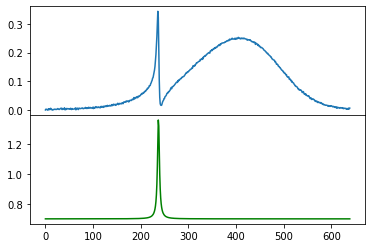

In [42]:
x,y = generate_batch(1)
f, a = plt.subplots(2,1, sharex=True)
a[0].plot(x.flatten(), label = 'cars')
a[1].plot(y.T+.7, label = 'true',c= 'g' )
plt.subplots_adjust(hspace=0)
print(x.flatten())

In [49]:
x1,y1 = generate_batch(1)
x1

array([[[ 8.96709411e-05],
        [-1.82266509e-03],
        [ 2.14818166e-03],
        [-1.13607871e-04],
        [-1.70437900e-03],
        [-1.19605318e-03],
        [-1.52017126e-03],
        [-2.52805648e-03],
        [ 2.56466885e-03],
        [ 2.71772572e-03],
        [-2.90010675e-03],
        [ 3.95296410e-03],
        [-4.46133866e-03],
        [ 2.88648588e-03],
        [ 8.10820456e-04],
        [-5.63997523e-04],
        [-2.87460781e-03],
        [ 4.79703006e-04],
        [-1.44176202e-03],
        [-3.09246206e-03],
        [ 5.55528751e-03],
        [-1.42198634e-03],
        [ 3.44921839e-03],
        [-1.51652920e-03],
        [ 2.26648174e-03],
        [-2.33415409e-03],
        [ 2.54829794e-03],
        [-2.40748756e-03],
        [-1.94513902e-03],
        [ 1.65412497e-03],
        [ 4.66606177e-03],
        [-6.92968150e-04],
        [-5.84909157e-04],
        [ 1.98427078e-03],
        [ 1.72846477e-03],
        [-2.97159122e-03],
        [ 1.58077233e-03],
 